# 06. Explainable AI (XAI) con LIME

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from lime import lime_image
from skimage.segmentation import mark_boundaries

## 1. Cargar el modelo

In [2]:

MODEL_PATH = '../models/ocr_cnn.h5'
DATA_DIR = '../data/processed/train_ocr'

model = load_model(MODEL_PATH, compile=False)
print("✓ Model loaded")

if os.path.exists(DATA_DIR):
    class_names = sorted(os.listdir(DATA_DIR))
    print(f"Classes ({len(class_names)}): {class_names}")
else:
    print("Data directory not found. Using default alphanumeric classes.")
    class_names = [str(i) for i in range(10)] + [chr(i) for i in range(65, 91)]

✓ Model loaded
Classes (35): ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


## 2. Define LIME

In [3]:
def predict_fn(images):
    """
    Wrapper function for LIME.
    Args:
        images: List of RGB images (N, 32, 32, 3)
    Returns:
        probs: Prediction probabilities (N, num_classes)
    """
    gray_images = []
    for img in images:
        if img.shape[-1] == 3:
            g = cv2.cvtColor(img.astype('float32'), cv2.COLOR_RGB2GRAY)
        else:
            g = img
        
        if g.shape[:2] != (32, 32):
            g = cv2.resize(g, (32, 32))
            
        if g.max() > 1.0:
            g = g / 255.0
            
        g = np.expand_dims(g, axis=-1)
        gray_images.append(g)
        
    batch = np.array(gray_images)
    
    probs = model.predict(batch, verbose=0)
    return probs

## 3. Inicialización del entorno

In [4]:
explainer = lime_image.LimeImageExplainer()

## 4. Explica predicciones con LIME

In [5]:
def explain_image(img_path, top_labels=5, hide_color=0, num_samples=1000):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (32, 32))
    
    probs = predict_fn([img])[0]
    pred_idx = np.argmax(probs)
    pred_label = class_names[pred_idx]
    confidence = probs[pred_idx]
    
    print(f"Explaining image: {os.path.basename(img_path)}")
    print(f"Prediction: '{pred_label}' ({confidence:.2%})")
    
    explanation = explainer.explain_instance(
        img.astype('double'), 
        predict_fn, 
        top_labels=top_labels, 
        hide_color=hide_color, 
        num_samples=num_samples
    )
    
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], 
        positive_only=True, 
        num_features=5, 
        hide_rest=False
    )
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[0].set_title(f"Original: {pred_label}")
    ax[0].axis('off')
    
    ax[1].imshow(mark_boundaries(temp / 255.0 + 0.5, mask))
    ax[1].set_title("LIME Explanation (Boundaries)")
    ax[1].axis('off')
    
    ind = explanation.top_labels[0]
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
    
    im = ax[2].imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
    ax[2].set_title("LIME Heatmap (Red=Pos, Blue=Neg)")
    ax[2].axis('off')
    plt.colorbar(im, ax=ax[2])
    
    plt.show()

## 5. Ejemplos

Explaining image: aug9048_7.jpg
Prediction: 'M' (100.00%)


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2450980392156863].


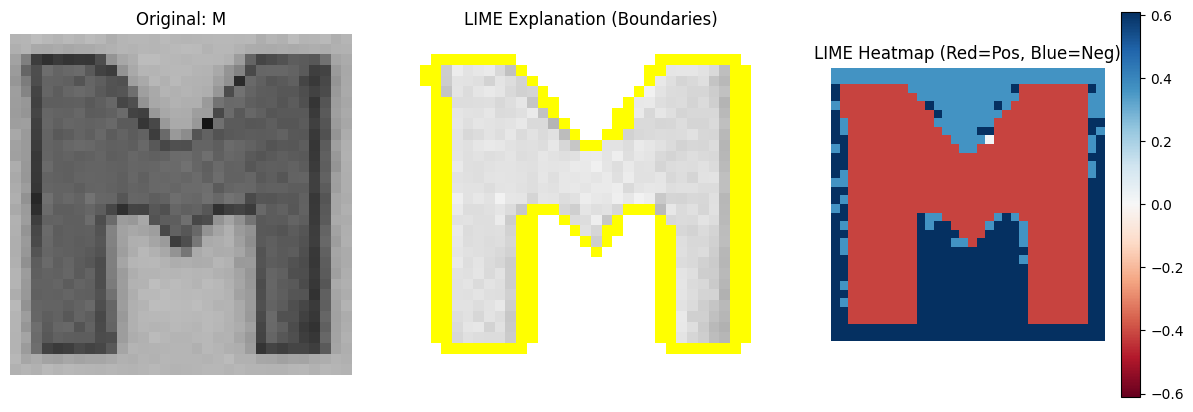

Explaining image: aug22155_4.jpg
Prediction: '4' (100.00%)


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.6607843137254902..1.1980392156862745].


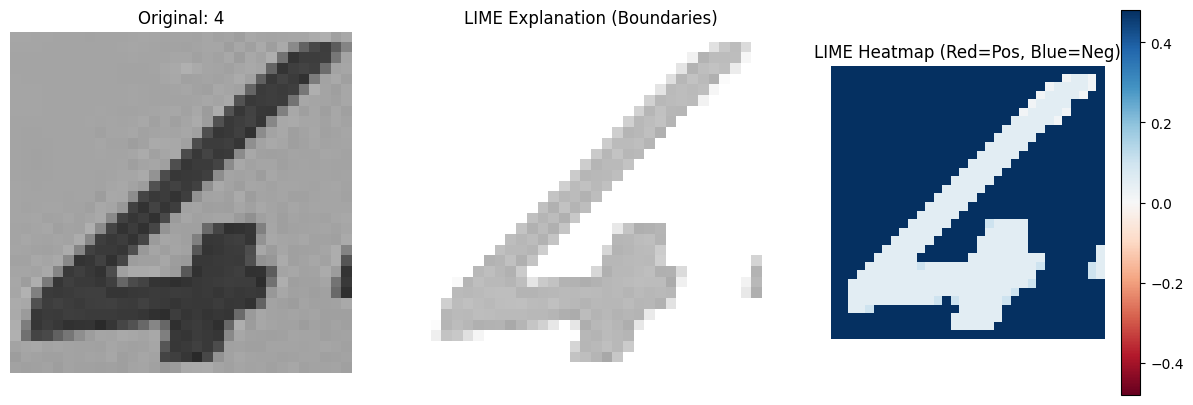

Explaining image: aug4940_9.jpg
Prediction: 'G' (100.00%)


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2058823529411766].


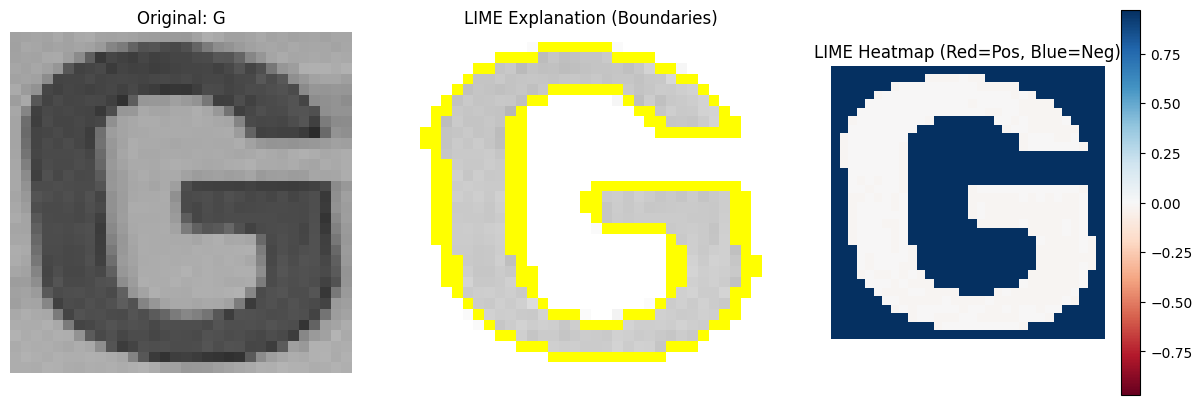

In [6]:

import random

samples = []
if os.path.exists(DATA_DIR):
    for _ in range(3):
        cls = random.choice(class_names)
        cls_dir = os.path.join(DATA_DIR, cls)
        if os.path.exists(cls_dir) and len(os.listdir(cls_dir)) > 0:
            img_name = random.choice(os.listdir(cls_dir))
            samples.append(os.path.join(cls_dir, img_name))

for img_path in samples:
    explain_image(img_path)